# Tutorial 9: Inference
## Overview
In this tutorial we are going to cover
* Run inference with transform method
    * Pipeline.transform
    * Network.transform

## Run inference with transform method

Running inference is to use the trained deep learning model to get prediction. Users can use `pipeline.transform` and `network.transform` to feed the data forward and get the computed result in any operation node. Here we are going to use an end-to-end example of MNIST image classification to demonstrate how to run inference. (the same example code of **Tutorial 8: Mode**)  

We first train a deep leaning model.

In [1]:
import fastestimator as fe
from fastestimator.dataset.data import mnist
from fastestimator.schedule import cosine_decay
from fastestimator.trace.adapt import LRScheduler
from fastestimator.trace.io import BestModelSaver
from fastestimator.trace.metric import Accuracy
from fastestimator.op.numpyop.univariate import ExpandDims, Minmax, CoarseDropout
from fastestimator.op.tensorop.loss import CrossEntropy
from fastestimator.op.tensorop.model import ModelOp, UpdateOp
from fastestimator.architecture.tensorflow import LeNet


train_data, eval_data = mnist.load_data()
test_data = eval_data.split(0.5)
model = fe.build(model_fn=LeNet, optimizer_fn="adam")

pipeline = fe.Pipeline(train_data=train_data,
                       eval_data=eval_data,
                       test_data=test_data,
                       batch_size=32,
                       ops=[ExpandDims(inputs="x", outputs="x"), #default mode=None
                            Minmax(inputs="x", outputs="x_out", mode=None),  
                            CoarseDropout(inputs="x_out", outputs="x_out", mode="train")])

network = fe.Network(ops=[ModelOp(model=model, inputs="x_out", outputs="y_pred"), #default mode=None
                          CrossEntropy(inputs=("y_pred", "y"), outputs="ce", mode="!infer"),
                          UpdateOp(model=model, loss_name="ce", mode="train")])

estimator = fe.Estimator(pipeline=pipeline,
                         network=network,
                         epochs=1,
                         traces=Accuracy(true_key="y", pred_key="y_pred")) # default mode=[eval, test]
estimator.fit()

FastEstimator-Warn: No ModelSaver Trace detected. Models will not be saved.
    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator-Start: step: 1; model_lr: 0.001; 
FastEstimator-Train: step: 1; ce: 2.306116; 
FastEstimator-Train: step: 100; ce: 1.3739773; steps/sec: 68.23; 
FastEstimator-Train: step: 200; ce: 1.0571189; steps/sec: 70.64; 
FastEstimator-Train: step: 300; ce: 1.3136258; steps/sec: 72.51; 
FastEstimator-Train: step: 400; ce: 1.0577172; steps/sec: 74.09; 
FastEstimator-Train: step: 500; ce: 1.0502439; steps/sec: 64.83; 
FastEstimator-Train: step: 600; ce: 1.0095195; steps/sec: 69.6

We create a customized function for the following showcase purpose 

In [2]:
import numpy as np
import tensorflow as tf

def print_dict_but_value(data):
    for key, value in data.items():
        if isinstance(value, np.ndarray):
            print("{}: ndarray with shape {}".format(key, value.shape))
        
        elif isinstance(value, tf.Tensor):
            print("{}: tf.Tensor with shape {}".format(key, value.shape))
        
        else:
            print("{}: {}".format(key, value))

The workflow of "infer" mode will look like the following graph.

<img src="../image/t09_infer_mode.PNG" alt="drawing" width="700"/>

Our goal is to feed the node "x" with input image and get the prediction result from node "y_pred". The input data need to be a dictionary with keys being node name and value being data itself. Here we take the first image of eval_data as the sample image and package it into a dictionary. 

In [3]:
import copy 

infer_data = {"x": copy.deepcopy(eval_data[0]["x"])}
print_dict_but_value(infer_data)

x: ndarray with shape (28, 28)


### Pipeline.transform
We use the pipeline object to call `transform` method. It will generate the dictionary of all nodes' data in the pipeline with all data in the form of Numpy array. 
<img src="../image/t09_infer_mode2.PNG" alt="drawing" width="700"/>

In [4]:
infer_data = pipeline.transform(infer_data, mode="infer")
print_dict_but_value(infer_data)

x: ndarray with shape (1, 28, 28, 1)
x_out: ndarray with shape (1, 28, 28, 1)


### Network.transform

We then use the network object to call `transform` method. Much alike with `pipeline.transform`, it will generate all nodes' data in the `network` with all data in the type of Tensor. The data type depends on the backend of the network. it is `tf.Tensor` with Tensorflow backend and `torch.Tensor` with Pytorch. Please check out **Tutorial 7: Network** for more detail about `Network` backend). 

<img src="../image/t09_infer_mode3.PNG" alt="drawing" width="700"/>

In [5]:
infer_data = network.transform(infer_data, mode="infer")
print_dict_but_value(infer_data)

x: tf.Tensor with shape (1, 28, 28, 1)
x_out: tf.Tensor with shape (1, 28, 28, 1)
y_pred: tf.Tensor with shape (1, 10)


Now we can visualize the input image and compare with its prediction class.

Prediction class is 1


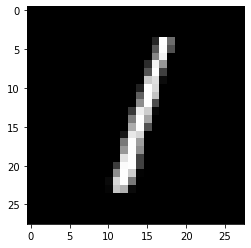

In [6]:
import matplotlib.pyplot as plt 
plt.imshow(np.squeeze(infer_data["x"]), cmap="gray")
print("Prediction class is {}".format(np.argmax(infer_data["y_pred"])))